In [28]:
import numpy as np
from nibabel import load
from nibabel.processing import resample_to_output
import os
from tqdm import tqdm

ROOT_DIR = '../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021'
MODEL_SHAPE = (240, 240, 155) # base brats model shape
OUTPUT_SHAPE = (256, 256, 155)

N_SAMPLES = 500
placeholder = np.zeros(shape=(N_SAMPLES, 3, *OUTPUT_SHAPE))
for idx, instance in enumerate(tqdm(os.listdir(ROOT_DIR)[: N_SAMPLES], position=0, leave=True)):
    # loading models
    mask = load(os.path.join(ROOT_DIR, instance, instance + '_seg.nii.gz'))
    flair = load(os.path.join(ROOT_DIR, instance, instance + '_flair.nii.gz'))
    t1ce = load(os.path.join(ROOT_DIR, instance, instance + '_t1ce.nii.gz'))

    # Compute the scaling factors (output will not be exactly the same as defined in OUTPUT_SHAPE)
    scale_factor = (MODEL_SHAPE[0] / OUTPUT_SHAPE[0],
                    MODEL_SHAPE[1] / OUTPUT_SHAPE[1],
                    MODEL_SHAPE[2] / OUTPUT_SHAPE[2])

    # Resample the image using trilinear interpolation
    resampled_mask = resample_to_output(mask, voxel_sizes=scale_factor, order=1).get_fdata()
    resampled_flair = resample_to_output(flair, voxel_sizes=scale_factor, order=1).get_fdata()
    resampled_t1ce = resample_to_output(t1ce, voxel_sizes=scale_factor, order=1).get_fdata()

    # Drop the last row, column, and slice to get the desired output size
    resampled_mask = resampled_mask[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]
    resampled_flair = resampled_flair[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]
    resampled_t1ce = resampled_t1ce[:OUTPUT_SHAPE[0], :OUTPUT_SHAPE[1], :OUTPUT_SHAPE[2]]

    # binarizing the mask (for simplicity), you can comment out this to keep all labels
    resampled_mask = (resampled_mask > 0).astype(np.float32)

    # saving models
    placeholder[idx] = np.stack([resampled_flair, resampled_t1ce, resampled_mask], axis=0)

# saving the dataset as a npy file
np.save('./data/brats_3d_dataset.npy', placeholder)

print('done!')


100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


done!


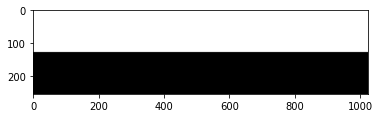

In [8]:
import torch
import matplotlib.pyplot as plt

x = torch.ones(8, 1, 128, 128)
y = torch.zeros(8, 1, 128, 128)

x = x.reshape(128, -1)
y = y.reshape(128, -1)
img = torch.cat([x, y], dim=0)

plt.imshow(img, cmap='gray')

